In [1]:
import torch
import numpy as np
from torchvision import datasets, transforms
from pathlib import Path
import spyrit.misc.walsh_hadamard as wh
import sys

from spyrit.misc.statistics import stat_walsh_stl10
# from spyrit.misc.statistics import *
from spyrit.misc.disp import *

from spyrit.learning.model_Had_DCAN import *

In [2]:
img_size = 64 # image size
M = 512
# M = 1024 # number of measurements
N0 = 2    # Image intensity (in photons)
bs = 5 # Batch size

#- Model and data paths
data_root = Path('../../data/')
stats_root = Path('../../data/stats_walsh')

In [3]:
#%% A batch of STL-10 test images
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(7)

transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

testset = \
    datasets.STL10(root=data_root, split='test',download=False, transform=transform)
testloader =  torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

In [4]:
inputs, _ = next(iter(testloader))
b,c,h,w = inputs.shape

In [5]:
# stat_walsh_stl10()
Cov = np.load(stats_root / Path("Cov_{}x{}.npy".format(img_size, img_size)))
Mean = np.load(stats_root / Path("Average_{}x{}.npy".format(img_size, img_size)))
H =  wh.walsh2_matrix(img_size)
# H =  wh.walsh2_matrix(img_size)/img_size


Ord = Cov2Var(Cov)
Perm = Permutation_Matrix(Ord)
Hperm = Perm@H;
Pmat = Hperm[:M,:];


Cov_had = Cov/img_size**2
Mean_had = Mean/img_size

Cov_perm = Perm@Cov@Perm.T;

In [6]:
x = inputs.view(b*c,w*h)
x_0 = torch.zeros_like(x)

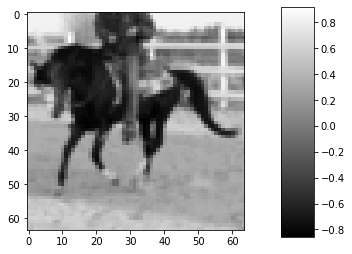

In [7]:
img = x[0,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

In [8]:
from spyrit.restructured.Updated_Had_Dcan import * 

In [9]:
FO_split = Split_Forward_operator(Pmat)
A_b = Bruit_Poisson_approx_Gauss(N0, FO_split)
SPP = Split_diag_poisson_preprocess(N0, M, w*h)

In [10]:
m = A_b(x)
y = SPP(m,FO_split)
var = SPP.sigma(m)

# Generalized_Orthogonal_Tikhonov (Validated)
## Instantiation

In [11]:
FO_split_had = Split_Forward_operator_ft_had(Pmat, Perm)
P = Generalized_Orthogonal_Tikhonov(sigma_prior = Cov_perm/4, M = M, N = h*w)
Pinv = Pinv_orthogonal()

## Test methode forward

tensor([[0.9946, 0.9879, 0.9842,  ..., 0.0837, 0.0838, 0.0836],
        [0.9956, 0.9895, 0.9868,  ..., 0.0986, 0.0986, 0.0960],
        [0.9937, 0.9854, 0.9815,  ..., 0.0723, 0.0721, 0.0709],
        [0.9959, 0.9906, 0.9879,  ..., 0.1077, 0.1071, 0.1079],
        [0.9957, 0.9901, 0.9868,  ..., 0.1045, 0.1022, 0.1015]])


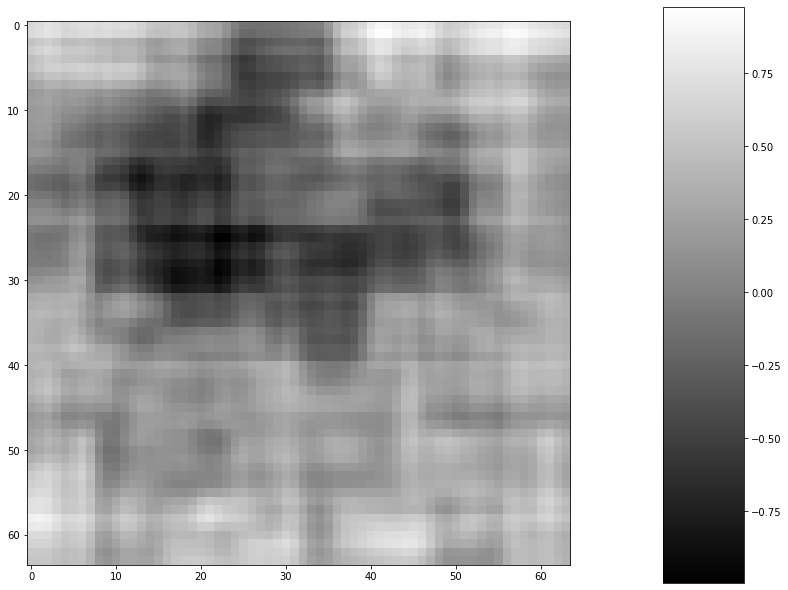

In [12]:
x_est = P(y, x_0, var, FO_split_had)
plt.rcParams['figure.figsize'] = [15, 10]
img = x_est[0,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

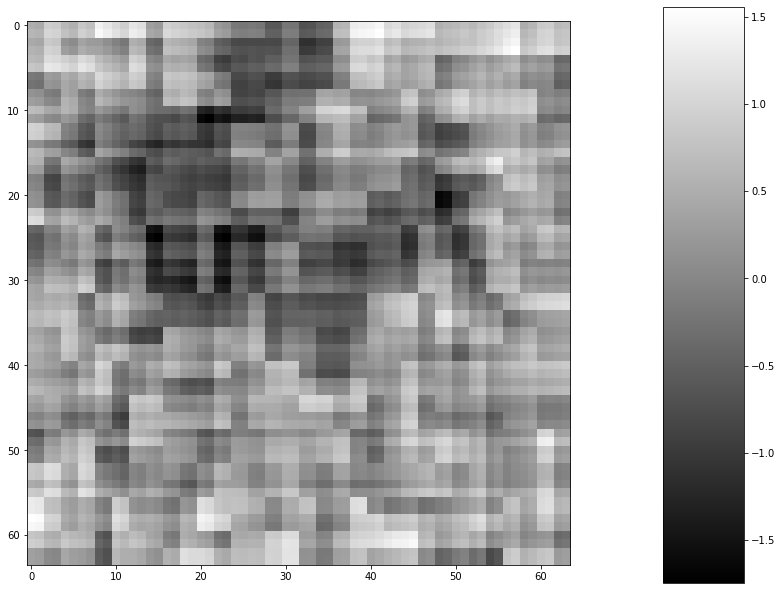

In [13]:
x_est = Pinv(y, FO_split_had)
plt.rcParams['figure.figsize'] = [15, 10]
img = x_est[0,:]
img = img.detach().numpy();
imagesc(np.reshape(img,(h,w)))

In [14]:
N0_list = [2, 5, 15, 50, 2500];
outlist = [];
out_pinv = [];
prevlist = [];
for N0 in N0_list:
    FO_split = Split_Forward_operator(Pmat)
    A_b = Bruit_Poisson_approx_Gauss(N0, FO_split)
    SPP = Split_diag_poisson_preprocess(N0, M, w*h)
    
    model = DenoiCompNet(img_size, M, Mean_had, Cov_had, variant=0, N0=N0, H=H)
    model.eval();
    
    m = A_b(x);
    y = SPP(m,FO_split);
    var = SPP.sigma(m);
    print("Variance new")
    print(var[0,:])
    # print(var[0,:])
    print("Sigma_1 new")
    Sig = P.denoise_layer.weight.data**2
    print(torch.mean(Sig))
    print(torch.std(Sig))
    print(torch.min(Sig))
    print(torch.max(Sig))
    
    x_Pinv = Pinv(y, FO_split);
    out_pinv.append(torch2numpy(x_Pinv.view(1,bs, 1, h, w)))
    
    # var = var*10;
    x_est = P(y, x_0, var, FO_split_had);
    outlist.append(torch2numpy(x_est.view(1,bs, 1, h, w)))
    
    recon_free = model.forward_reconstruct_mmse(m, b, c, h, w)
    prevlist.append(torch2numpy(recon_free.view(1,bs, 1, h, w)))
    

Measurement to image domain: statistical completion (no mean)
Varying N0 = 2 +/- 0
Denoised Measurements
Variance new
tensor([1122.9508, 1132.2261, 1128.1880, 1104.7269, 1153.0145, 1103.4719,
        1124.0112, 1084.4208, 1120.2814, 1115.1042, 1124.0120, 1116.8571,
        1119.7627, 1093.1418, 1109.4189, 1094.5618, 1117.8575, 1122.7612,
        1114.7155, 1108.8696, 1114.0491, 1093.3398, 1125.1768, 1112.5601,
        1126.8938, 1146.7727, 1122.5110, 1123.3424, 1118.9171, 1095.8665,
        1112.1829, 1128.8545, 1115.7374, 1112.0800, 1101.4531, 1109.1348,
        1113.1027, 1119.0950, 1129.9086, 1138.4478, 1140.5386, 1136.1476,
        1149.8221, 1132.1552, 1101.4802, 1109.8362, 1115.0283, 1130.4854,
        1112.0469, 1096.4977, 1127.7207, 1115.1726, 1116.5430, 1122.5837,
        1111.3834, 1108.0240, 1124.3118, 1122.5222, 1130.0371, 1119.3337,
        1116.3643, 1093.7178, 1108.3872, 1147.0040, 1107.4458, 1131.4021,
        1125.1042, 1098.1865, 1099.0164, 1154.3025, 1160.1370, 1134.

In [15]:
# N0_list = [2, 5, 15, 50, 2500];
# outlist = [];
# out_pinv = [];
# # prevlist = [];
# for N0 in N0_list:
#     FO_split = Split_Forward_operator(Pmat)
#     A_b = Bruit_Poisson_approx_Gauss(N0, FO_split)
#     SPP = Split_diag_poisson_preprocess(N0, M, w*h)
    
# #     model = DenoiCompNet(img_size, M, Mean_had, Cov_had, variant=0, N0=N0, H=H)
# #     model.eval();
    
#     m = A_b(x);
#     y = SPP(m,FO_split);
#     var = SPP.sigma(m);
#     out_pinv.append(torch2numpy(x_Pinv.view(1,bs, 1, h, w)))
    
#     # var = var*10;
#     x_est = P(y, x_0, var, FO_split_had);
#     outlist.append(torch2numpy(x_est.view(1,bs, 1, h, w)))
    
#     # recon_free = model.forward_reconstruct_mmse(m, b, c, h, w)
#     # prevlist.append(torch2numpy(recon_free.view(1,bs, 1, h, w)))
    

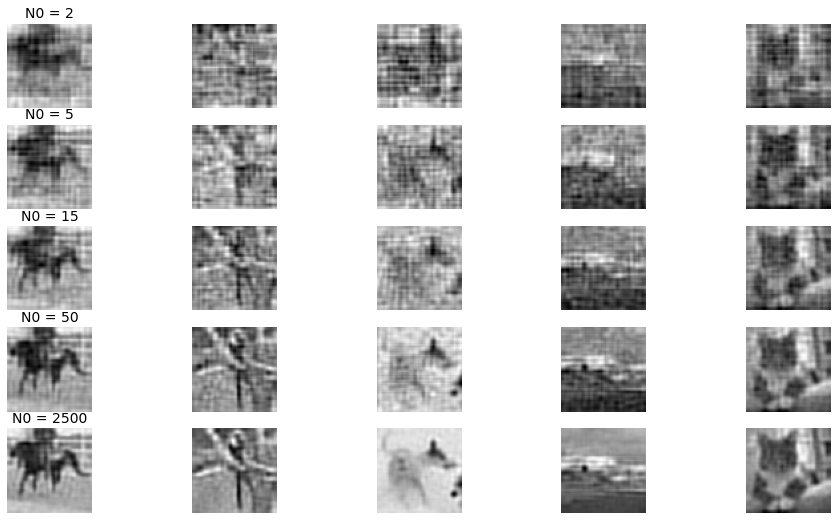

In [16]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [50, 20]

nb_disp_frames = len(N0_list)
outputs_0 = outlist;
title_lists_0 = []
title_lists_0.append(["N0 = 2"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 5"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 15"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 50"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 2500"]+["" for i in range(bs-1)])
compare_video_frames(outputs_0, nb_disp_frames, title_lists_0, savefig = '');

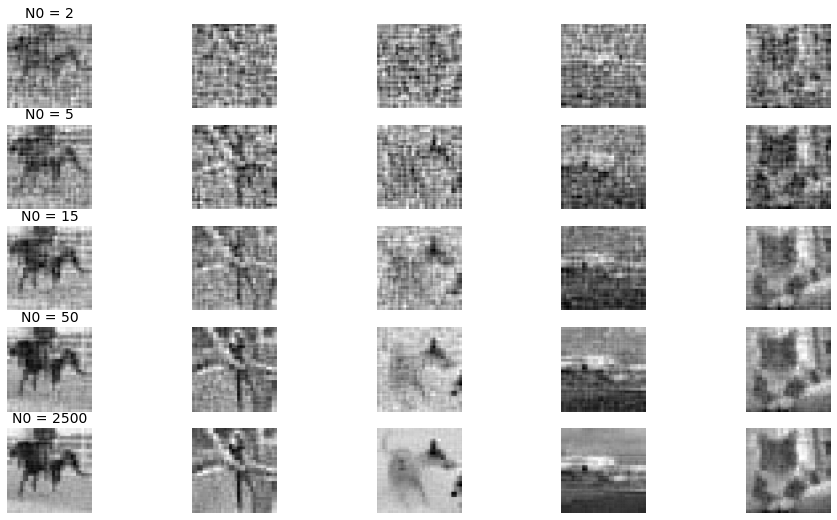

In [17]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [50, 20]

nb_disp_frames = len(N0_list)
outputs_0 = out_pinv;
title_lists_0 = []
title_lists_0.append(["N0 = 2"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 5"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 15"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 50"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 2500"]+["" for i in range(bs-1)])
compare_video_frames(outputs_0, nb_disp_frames, title_lists_0,savefig = '');

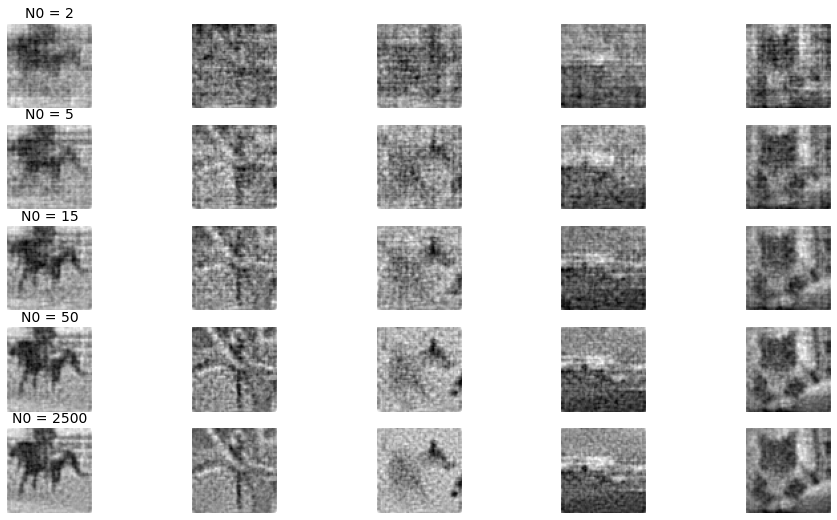

In [18]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [50, 20]

nb_disp_frames = len(N0_list)
outputs_0 = prevlist;
title_lists_0 = []
title_lists_0.append(["N0 = 2"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 5"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 15"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 50"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = 2500"]+["" for i in range(bs-1)])
compare_video_frames(outputs_0, nb_disp_frames, title_lists_0,savefig = '');

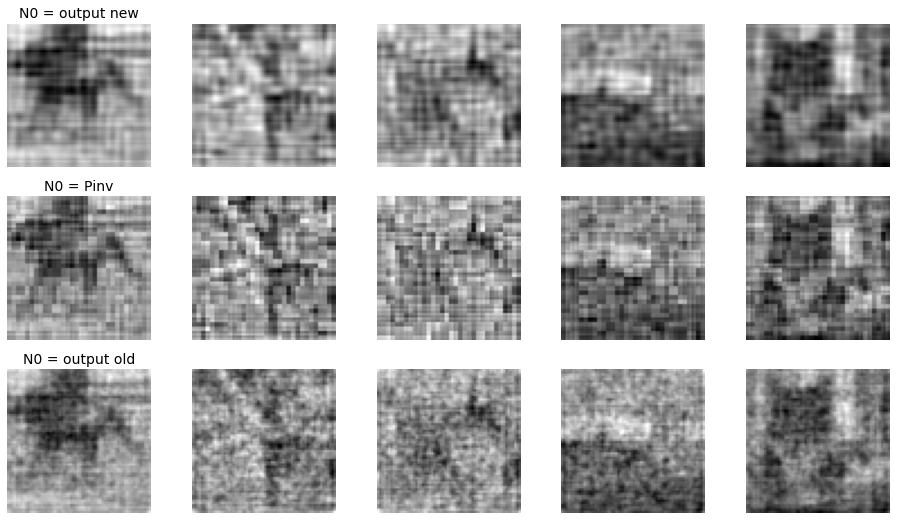

In [19]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [50, 20]

nb_disp_frames = len(N0_list)
outputs_0 = [outlist[1], out_pinv[1], prevlist[1]];
title_lists_0 = []
title_lists_0.append(["N0 = output new"]+["" for i in range(bs-1)]) 
title_lists_0.append(["N0 = Pinv"]+["" for i in range(bs-1)])
title_lists_0.append(["N0 = output old"]+["" for i in range(bs-1)])
compare_video_frames(outputs_0, nb_disp_frames, title_lists_0,savefig = '');

In [26]:
np.linalg.norm(outlist[0][0,0,0,:,:]-torch2numpy(inputs[0,0,:,:]))

16.741405

In [27]:
np.linalg.norm(prevlist[0][0,0,0,:,:]-torch2numpy(inputs[0,0,:,:]))

256290.05

In [22]:
outlist[0].shape

(1, 5, 1, 64, 64)

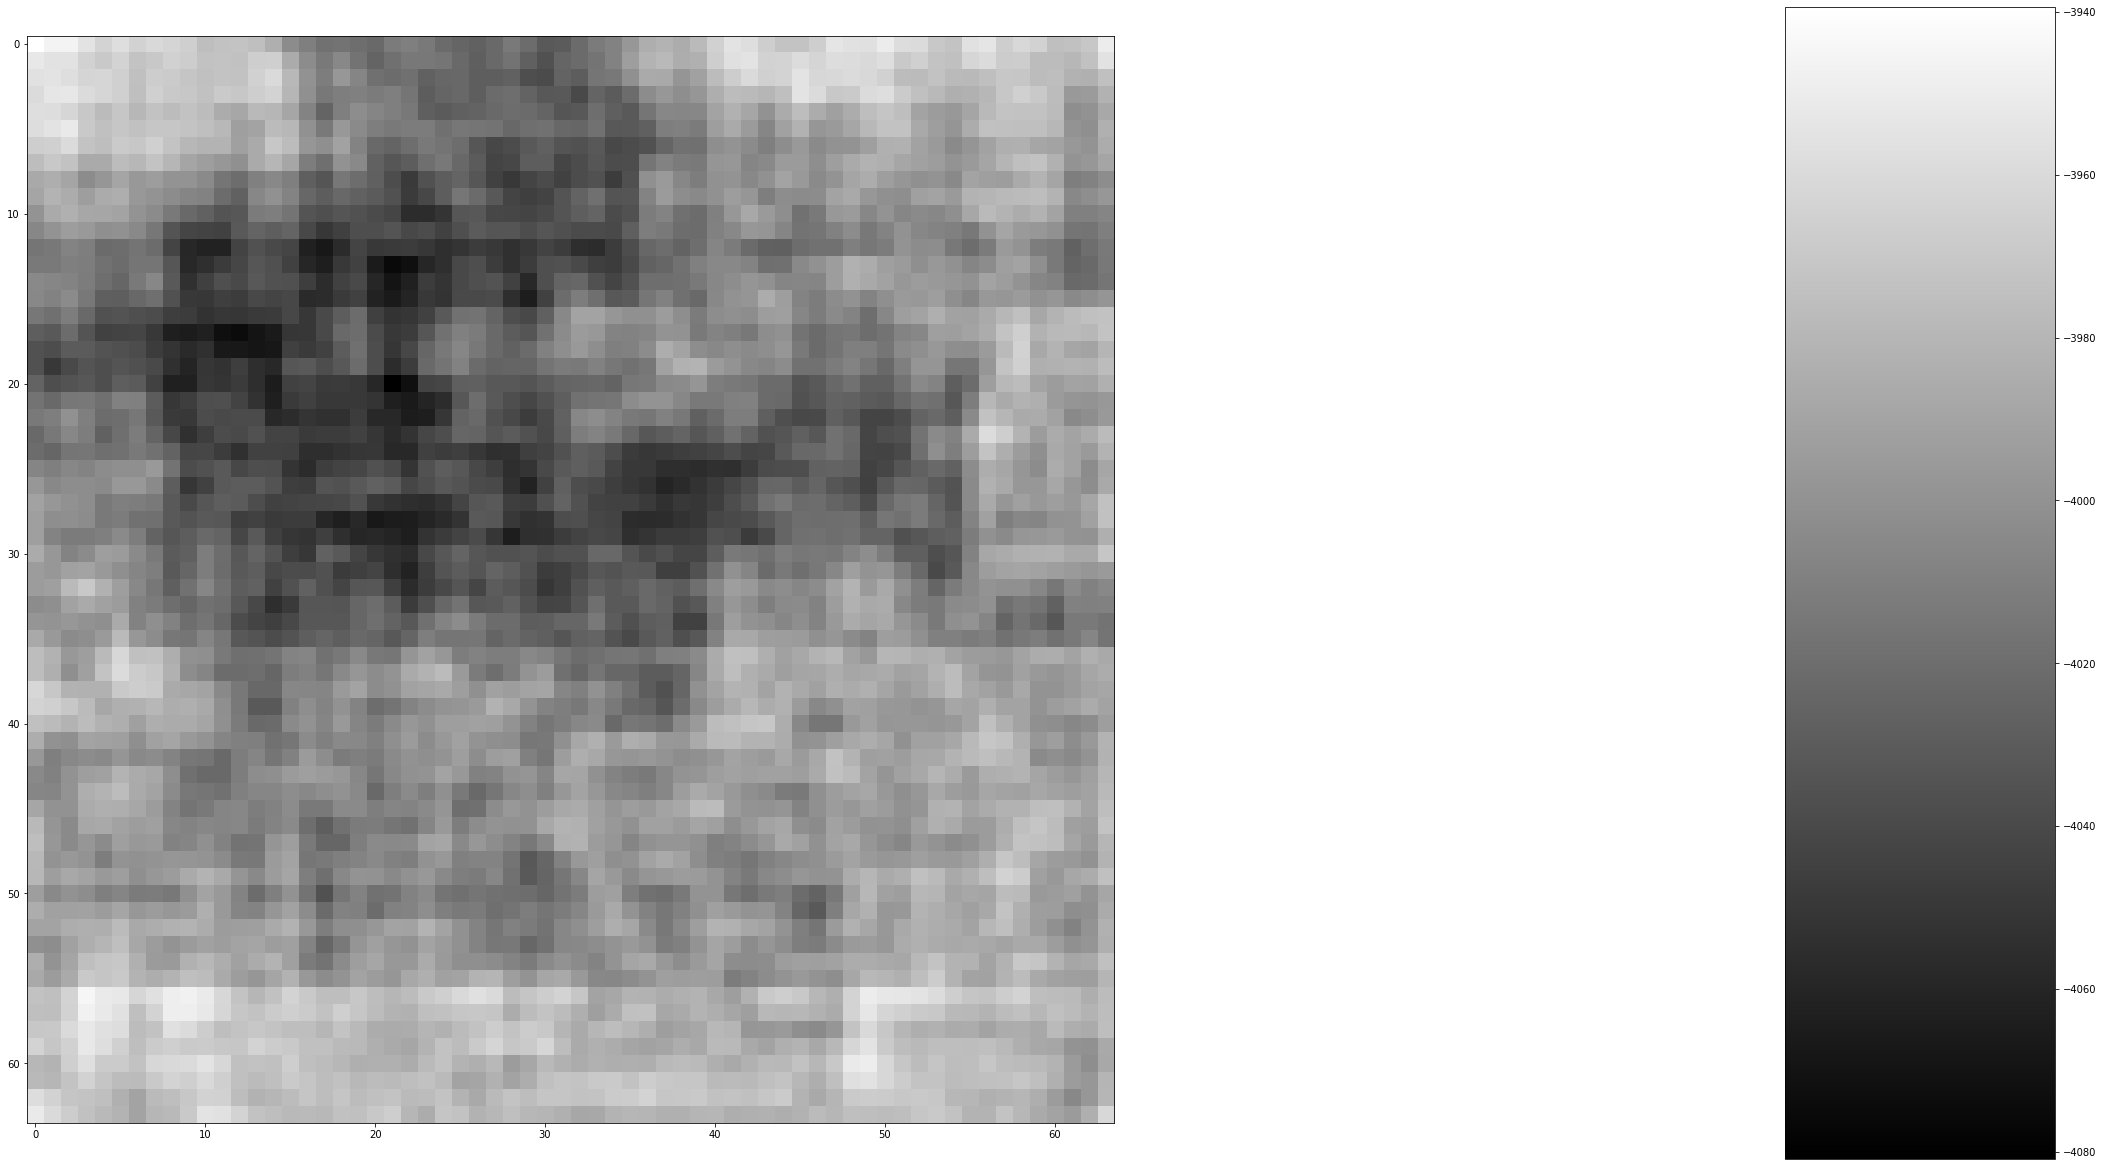

In [28]:
imagesc(prevlist[0][0,0,0,:,:])